In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import os,sys,glob, h5py

from braintv_ephys_dev.workstation.danield import generalephys as ephys
from braintv_ephys_dev.workstation.danield.generalephys import placeAxesOnGrid, cleanAxes
from braintv_ephys_dev.workstation.danield import utils
from braintv_ephys_dev.workstation.danield import rf_analysis
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth
from braintv_ephys_dev.workstation.danield import reliability_and_precision as rp


#import from xiaoxuan's workstation
sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/braintv_ephys_dev/workstation/jiaxx')
from sparseness_life import sparseness

#import allensdk for corona plots
#sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/allensdk/allensdk')
#import allensdk.brain_observatory.circle_plots as cp

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

failed to import CV2 in core.utilities


/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
folder = '/Volumes/DATA2/temporal/nwbs' 
#paths = glob.glob(folder+'/*.nwb')
v1_paths = [os.path.join(folder,'M276039_insertion2_V1_angled_sort2_2.nwb'),
        os.path.join(folder,'M310008_07-27-13_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_07-35-06_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_08-23-22_v1_angled1_d2.nwb'),
         os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
        os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
            os.path.join(folder,'M310017_09-23-41_v1_angled1.nwb'),
            os.path.join(folder,'M227382_insertion1_withDepths11.nwb'),
           os.path.join(folder,'M227398_insertion1_withEyetracking.nwb'),
            #os.path.join(folder,'M230381_insertion2_V1.nwb'),
            os.path.join(folder,'M260686_insertion1_V1_withEyetracking3.nwb'),
            os.path.join(folder,'M270512_insertion2_V1_angled3_6.nwb'),
            os.path.join(folder,'M276038_insertion3_V1_angled_7.nwb'),
           ]
lgn_paths = [#os.path.join(folder,'M227382_insertion2_LGN.nwb'),
            os.path.join(folder,'M260866_insertion2_withEyetracking1.nwb'),
            os.path.join(folder,'M270511_insertion5.nwb')]
dual_paths = glob.glob(os.path.join(folder,'M31989*.nwb'))
eye_paths = glob.glob(os.path.join(folder,'withEyetracking','*.nwb'))
figure_folder = '/Volumes/DATA2/temporal/figures'

In [3]:
dfs = [utils.df_from_nwb(path) for path in eye_paths]
df = pd.concat(dfs,ignore_index=True)

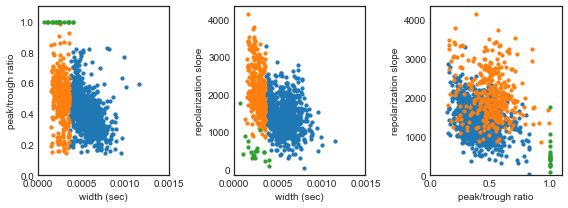

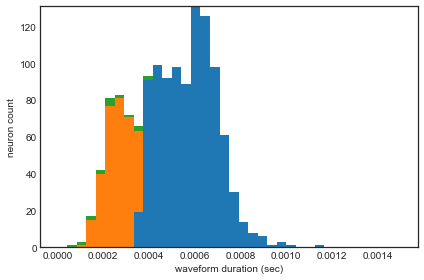

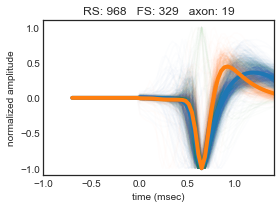

In [4]:
df = utils.classify_waveform_shape(df,plots=True,basepath='/Users/administrator/Dropbox/allenTransfer/temporal_figs')

In [5]:
structure = []
for index in df.index:
    if df.probe[index] == 'V1' or df.probe[index] == 'LGN':
        structure.extend([df.probe[index]])
    else:
        if df.depth[index] < 1000.:
            structure.extend(['V1'])
        else:
            if df.depth[index] > 1900.:
                structure.extend(['LGN'])
            else:
                structure.extend(['other'])
df['structure']=structure
df_lgn = df[df.structure=='LGN']
df_v1 = df[df.structure=='V1']

In [6]:
dfv = pd.concat([df_v1,df_lgn])

In [7]:
nwbs={}
for nwb_path in dfv.nwb_id.unique():
    try:
        nwbs[nwb_path]=h5py.File(nwb_path)
    except:
        print nwb_path

In [8]:
import seaborn as sns
sns.set_palette(sns.cubehelix_palette(10)[::-1])
plt.rcParams['axes.labelsize']=14

## decoding with K-nearest neighbors

In [20]:
from sklearn import neighbors
from sklearn import svm

get raw data

In [12]:
nwb_data = nwbs['/Volumes/DATA2/temporal/nwbs/withEyetracking/M310008_07-35-06_v1_angled_d_withEyetracking.nwb']

get labels from the data

In [10]:
image_ids = np.matlib.repmat(np.arange(1,119),80,1).flatten()
# shuffled_image_ids = np.array(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['data'])

In [401]:
nwb_data['processing'].keys()

[u'V1', u'lefteye', u'righteye', u'running']

In [14]:
probename='V1'

get tensors from the data<br></br>
tensors are Ntrials x Nunits

first, spike counts as tensors

In [20]:
images_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_X_counts[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                else: images_X_counts[i][j] = 0
            else: images_X_counts[i][j] = 0

 9439/9440 /Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_25082017_withEyetracking1.nwb 99.9894067797%


first spike *latency* as tensors

In [25]:
images_X_latency = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_X_latency[i][j] = post_spikes[0] -  stimulus_time
                else: images_X_latency[i][j] = 0
            else: images_X_latency[i][j] = 0

 9439/9440 /Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_25082017_withEyetracking1.nwb 99.9894067797%


then, first spike latency [after being adjusted by the population latency [reference frame]] as the tensor

In [63]:
images_X_latency.shape

(9440, 76)

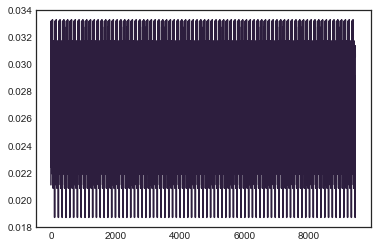

In [64]:
plt.plot(np.tile(np.mean(a[:,:,20],axis=1),80))

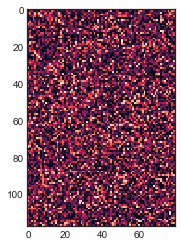

In [57]:
for cell in range(76):
    np.tile(np.mean(images_X_latency[:,cell].reshape(118,80),axis=1),80)

In [72]:
#get the global dt for each image presentation. 
#should a 1d array length imagesxpresentations, which in this case is 118x80
global_dts = np.zeros(np.shape(images_X_counts))

#slice the latency tensor to get all the latencies for a given image. this should then be 118 x Nunits
#get a a mean 
for cell in range(76):
    global_dts[:,cell]=np.tile(np.mean(images_X_latency[:,cell].reshape(118,80),axis=1),80)

images_X_latency_corrected = images_X_latency - global_dts
# images_X_latency_corrected = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
#                      len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
# window = 0.1
# for i,image in enumerate(image_ids):
#     print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
#     for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
#             times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
#             stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
#             post_spikes = times1[times1 > stimulus_time]
#             if len (post_spikes) > 0:
#                 if post_spikes[0] < stimulus_time+window:
#                     images_X_latency_corrected[i][j] = post_spikes[0] -  stimulus_time - global_dts[i]
#                 else: images_X_latency_corrected[i][j] = 0
#             else: images_X_latency_corrected[i][j] = 0

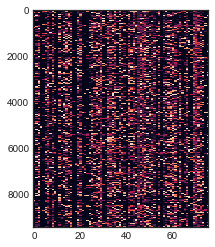

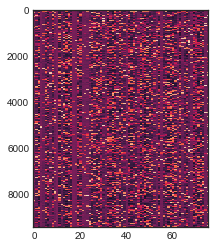

In [73]:
plt.imshow(images_X_latency)
plt.gca().set_aspect(.01)
plt.figure()
plt.imshow(images_X_latency_corrected)
plt.gca().set_aspect(.01)

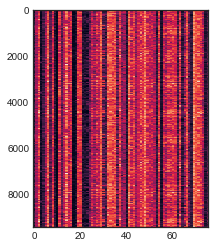

In [70]:
plt.imshow(global_dts)
plt.gca().set_aspect(.01)

In [16]:
images_shuffled_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['timestamps']),
                     len(np.array(nwb_data['processing']['B']['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing']['B']['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing']['B']['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_shuffled_X[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                else: images_shuffled_X[i][j] = 0
            else: images_shuffled_X[i][j] = 0

KeyError: "Unable to open object (object 'natural_scenes_shuffled' doesn't exist)"

In [42]:
images_X = images_X_counts

In [29]:
diffs=[]
good_images = []
for image_no in range(118):
    responses = images_X[image_no::118,:]
    means = np.mean(responses,axis=1)
    diffs.extend([np.max(means)-np.min(means)]) 
diff_images = image_ids[np.argsort(diffs)[::-1]][:30]

maxs=[]
good_images = []
for image_no in range(118):
    responses = images_X[image_no::118,:]
    means = np.mean(responses,axis=1)
    maxs.extend([np.max(means)]) 
big_images = image_ids[np.argsort(maxs)[::-1]][:30]

In [30]:
good_images = big_images
# good_images = diff_images
# good_images = image_ids

In [31]:
images_sub = images_X[np.in1d(image_ids, good_images),:]
images_sub_ids = image_ids[np.in1d(image_ids, good_images)]

In [32]:
images_sub.shape

(2400, 76)

In [33]:
test_size = 60
# images_X_train = images_X[:-test_size]
# images_X_test= images_X[-test_size:]
# images_Y_test = image_ids[-test_size:]
# images_Y_train= image_ids[:-test_size]
images_X_train = images_sub[test_size:]
images_X_test= images_sub[:test_size]
images_Y_test = images_sub_ids[:test_size]
images_Y_train= images_sub_ids[test_size:]

50.0

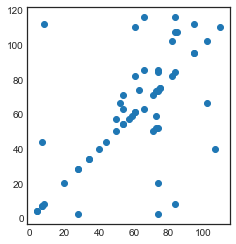

In [34]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

In [36]:
all_predictions = np.zeros((80,30))
correct=  np.zeros((80,30))
for i in range(80):
    test_size = 30
    test_indices = np.arange(30*i,30*i+30,1)
    train_indices = np.delete(np.arange(80*30),test_indices)
    images_X_train = images_sub[train_indices]
    images_X_test= images_sub[test_indices]
    images_Y_test = images_sub_ids[test_indices]
    images_Y_train= images_sub_ids[train_indices]
    KNN.fit(images_X_train, images_Y_train) 
    predictions = KNN.predict(images_X_test)
    all_predictions[i,:]=predictions
    correct[i,:]=predictions == images_Y_test

In [ ]:
all_predictions = np.zeros((80,30))
correct=  np.zeros((80,30))
for i in range(80):
    test_size = 30
    test_indices = np.arange(30*i,30*i+30,1)
    train_indices = np.delete(np.arange(80*30),test_indices)
    images_X_train = images_sub[train_indices]
    images_X_test= images_sub[test_indices]
    images_Y_test = images_sub_ids[test_indices]
    images_Y_train= images_sub_ids[train_indices]
    KNN.fit(images_X_train, images_Y_train) 
    predictions = KNN.predict(images_X_test)
    all_predictions[i,:]=predictions
    correct[i,:]=predictions == images_Y_test

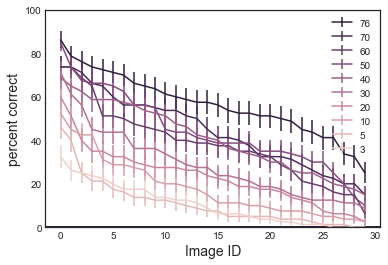

In [43]:
savefig=False
popsize = [76,70,60,50,40,30,20,10,5,3]
for no_neurons in popsize:
    if no_neurons != 76:
        images_sub = images_X[np.in1d(image_ids, good_images),:]
        images_sub=images_sub[:,np.random.randint(0,75,no_neurons)]
    else: images_sub = images_X[np.in1d(image_ids, good_images),:]
    
        
    all_predictions = np.zeros((80,30))
    correct=  np.zeros((80,30))
    
    for i in range(80):
        test_size = 30
        test_indices = np.arange(30*i,30*i+30,1)
        train_indices = np.delete(np.arange(80*30),test_indices)
        images_X_train = images_sub[train_indices]
        images_X_test= images_sub[test_indices]
        images_Y_test = images_sub_ids[test_indices]
        images_Y_train= images_sub_ids[train_indices]
        KNN.fit(images_X_train, images_Y_train) 
        predictions = KNN.predict(images_X_test)
        all_predictions[i,:]=predictions
        correct[i,:]=predictions == images_Y_test
    sorts = np.argsort(np.mean(correct,axis=0))[::-1]
    plt.errorbar(np.arange(30),
                 np.mean(correct,axis=0)[sorts]*100,
                 yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80)*100,
                 label=str(no_neurons))
    plt.gca().axhline(0.03)#,ls='r--')
    plt.ylim(0,100)
plt.legend()
plt.xlabel("Image ID")
plt.ylabel("percent correct")
if savefig:
    plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/KNN_popsize.eps',format='eps')

In [39]:
images_X = images_X_latency
test_size = 60
# images_X_train = images_X[:-test_size]
# images_X_test= images_X[-test_size:]
# images_Y_test = image_ids[-test_size:]
# images_Y_train= image_ids[:-test_size]
images_X_train = images_sub[test_size:]
images_X_test= images_sub[:test_size]
images_Y_test = images_sub_ids[:test_size]
images_Y_train= images_sub_ids[test_size:]

6.666666666666667

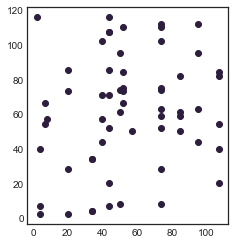

In [40]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

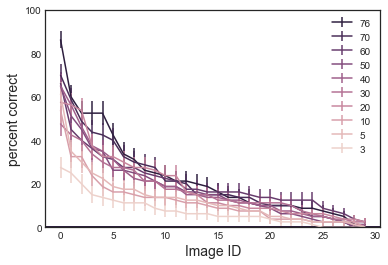

In [41]:
savefig=True
popsize = [76,70,60,50,40,30,20,10,5,3]
for no_neurons in popsize:
    if no_neurons != 76:
        images_sub = images_X[np.in1d(image_ids, good_images),:]
        images_sub=images_sub[:,np.random.randint(0,75,no_neurons)]
    else: images_sub = images_X[np.in1d(image_ids, good_images),:]
    
        
    all_predictions = np.zeros((80,30))
    correct=  np.zeros((80,30))
    
    for i in range(80):
        test_size = 30
        test_indices = np.arange(30*i,30*i+30,1)
        train_indices = np.delete(np.arange(80*30),test_indices)
        images_X_train = images_sub[train_indices]
        images_X_test= images_sub[test_indices]
        images_Y_test = images_sub_ids[test_indices]
        images_Y_train= images_sub_ids[train_indices]
        KNN.fit(images_X_train, images_Y_train) 
        predictions = KNN.predict(images_X_test)
        all_predictions[i,:]=predictions
        correct[i,:]=predictions == images_Y_test
    sorts = np.argsort(np.mean(correct,axis=0))[::-1]
    plt.errorbar(np.arange(30),
                 np.mean(correct,axis=0)[sorts]*100,
                 yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80)*100,
                 label=str(no_neurons))
    plt.gca().axhline(0.03)#,ls='r--')
    plt.ylim(0,100)
plt.legend()
plt.xlabel("Image ID")
plt.ylabel("percent correct")
if savefig:
    plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/KNN_popsize_latency.eps',format='eps')

In [21]:
latency_corrected_tensors.keys()

['/Volumes/DATA2/temporal/nwbs/withEyetracking/M310008_07-35-06_v1_angled_d_withEyetracking.nwb',
 '/Volumes/DATA2/temporal/nwbs/withEyetracking/M319891_dual_01092017_withEyetracking.nwb',
 '/Volumes/DATA2/temporal/nwbs/withEyetracking/M310008_07-27-13_v1_angled_d_withEyetracking.nwb',
 '/Volumes/DATA2/temporal/nwbs/withEyetracking/M310008_08-52-48_v1_angled3_d2_withEyetracking.nwb']

## latency for all V1 data

In [21]:

count_tensors={}
latency_tensors={}
latency_corrected_tensors={}

In [22]:
for nwb_id in df.nwb_id.unique():
    if nwb_id not in latency_corrected_tensors.keys():
        nwb_data = nwbs[nwb_id]
        if 'natural_scenes' in nwb_data['stimulus']['presentation'].keys():
            for probename in nwb_data['processing'].keys():
                if 'UnitTimes' in nwb_data['processing'][probename].keys():
                    image_ids = np.matlib.repmat(np.arange(1,119),len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118,1).flatten()
                    count_tensors[nwb_id]={}
                    latency_tensors[nwb_id]={}
                    latency_corrected_tensors[nwb_id]={}
                    images_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                                         len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
                    window = 0.1
                    for i,image in enumerate(image_ids):
                        print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
                        for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                                times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
                                stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
                                post_spikes = times1[times1 > stimulus_time]
                                if len (post_spikes) > 0:
                                    if post_spikes[0] < stimulus_time+window:
                                        images_X_counts[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                                    else: images_X_counts[i][j] = 0
                                else: images_X_counts[i][j] = 0

                    images_X_latency = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
                    window = 0.1
                    for i,image in enumerate(image_ids):
                        print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
                        for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                                times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
                                stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
                                post_spikes = times1[times1 > stimulus_time]
                                if len (post_spikes) > 0:
                                    if post_spikes[0] < stimulus_time+window:
                                        images_X_latency[i][j] = post_spikes[0] -  stimulus_time
                                    else: images_X_latency[i][j] = 0
                                else: images_X_latency[i][j] = 0


                    global_dts = np.zeros(np.shape(images_X_counts))
                    #slice the latency tensor to get all the latencies for a given image. this should then be 118 x Nunits
                    #get a a mean 
                    for cell in range(len(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                        global_dts[:,cell]=np.tile(np.mean(images_X_latency[:,cell].reshape(118,len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118),axis=1),len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118)
                    images_X_latency_corrected = images_X_latency - global_dts  

                count_tensors[nwb_id][probename]=images_X_counts
                latency_tensors[nwb_id][probename]=images_X_latency
                latency_corrected_tensors[nwb_id][probename]=images_X_latency_corrected

 5899/5900 /Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_25082017_withEyetracking1.nwb 99.9830508475%


In [ ]:
pkl.dump(count_tensors)

In [ ]:
for nwb_id in df.nwb_id.unique():
    if nwb_id not in latency_corrected_tensors.keys():
        nwb_data = nwbs[nwb_id]
        if 'natural_scenes' in nwb_data['stimulus']['presentation'].keys():
            for probename in nwb_data['processing'].keys():
                if 'UnitTimes' in nwb_data['processing'][probename].keys():
                    image_ids = np.matlib.repmat(np.arange(1,119),len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118,1).flatten()
                    count_tensors[nwb_id]={}
                    latency_tensors[nwb_id]={}
                    latency_corrected_tensors[nwb_id]={}
                    images_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                                         len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
                    
                    sponts = [] #np.shape(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))[0]
                    for i,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                       
                    window = 0.1
                    for i,image in enumerate(image_ids):
                        print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
                        for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                                times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
                                stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
                                post_spikes = times1[times1 > stimulus_time]
                                if len (post_spikes) > 0:
                                    if post_spikes[0] < stimulus_time+window:
                                        images_X_counts[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                                    else: images_X_counts[i][j] = 0
                                else: images_X_counts[i][j] = 0

                    images_X_latency = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
                    window = 0.1
                    for i,image in enumerate(image_ids):
                        print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
                        for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                                times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
                                stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
                                post_spikes = times1[times1 > stimulus_time]
                                if len (post_spikes) > 0:
                                    if post_spikes[0] < stimulus_time+window:
                                        images_X_latency[i][j] = post_spikes[0] -  stimulus_time
                                    else: images_X_latency[i][j] = 0
                                else: images_X_latency[i][j] = 0


                    global_dts = np.zeros(np.shape(images_X_counts))
                    #slice the latency tensor to get all the latencies for a given image. this should then be 118 x Nunits
                    #get a a mean 
                    for cell in range(len(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
                        global_dts[:,cell]=np.tile(np.mean(images_X_latency[:,cell].reshape(118,len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118),axis=1),len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])/118)
                    images_X_latency_corrected = images_X_latency - global_dts  

                count_tensors[nwb_id][probename]=images_X_counts
                latency_tensors[nwb_id][probename]=images_X_latency
                latency_corrected_tensors[nwb_id][probename]=images_X_latency_corrected

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import os,sys,glob, h5py

from braintv_ephys_dev.workstation.danield import generalephys as ephys
from braintv_ephys_dev.workstation.danield.generalephys import placeAxesOnGrid, cleanAxes
from braintv_ephys_dev.workstation.danield import utils
from braintv_ephys_dev.workstation.danield import rf_analysis
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth
from braintv_ephys_dev.workstation.danield import reliability_and_precision as rp


#import from xiaoxuan's workstation
sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/braintv_ephys_dev/workstation/jiaxx')
from sparseness_life import sparseness

#import allensdk for corona plots
#sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/allensdk/allensdk')
#import allensdk.brain_observatory.circle_plots as cp

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

failed to import CV2 in core.utilities


/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
folder = '/Volumes/DATA2/temporal/nwbs' 
#paths = glob.glob(folder+'/*.nwb')
v1_paths = [os.path.join(folder,'M276039_insertion2_V1_angled_sort2_2.nwb'),
        os.path.join(folder,'M310008_07-27-13_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_07-35-06_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_08-23-22_v1_angled1_d2.nwb'),
         os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
        os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
            os.path.join(folder,'M310017_09-23-41_v1_angled1.nwb'),
            os.path.join(folder,'M227382_insertion1_withDepths11.nwb'),
           os.path.join(folder,'M227398_insertion1_withEyetracking.nwb'),
            #os.path.join(folder,'M230381_insertion2_V1.nwb'),
            os.path.join(folder,'M260686_insertion1_V1_withEyetracking3.nwb'),
            os.path.join(folder,'M270512_insertion2_V1_angled3_6.nwb'),
            os.path.join(folder,'M276038_insertion3_V1_angled_7.nwb'),
           ]
lgn_paths = [#os.path.join(folder,'M227382_insertion2_LGN.nwb'),
            os.path.join(folder,'M260866_insertion2_withEyetracking1.nwb'),
            os.path.join(folder,'M270511_insertion5.nwb')]
dual_paths = glob.glob(os.path.join(folder,'M31989*.nwb'))
eye_paths = glob.glob(os.path.join(folder,'withEyetracking','*.nwb'))
figure_folder = '/Volumes/DATA2/temporal/figures'

In [3]:
dfs = [utils.df_from_nwb(path) for path in eye_paths]
df = pd.concat(dfs,ignore_index=True)

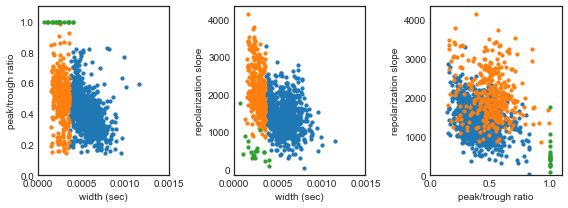

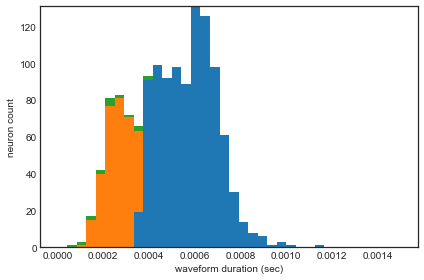

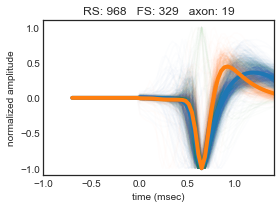

In [4]:
df = utils.classify_waveform_shape(df,plots=True,basepath='/Users/administrator/Dropbox/allenTransfer/temporal_figs')

In [5]:
structure = []
for index in df.index:
    if df.probe[index] == 'V1' or df.probe[index] == 'LGN':
        structure.extend([df.probe[index]])
    else:
        if df.depth[index] < 1000.:
            structure.extend(['V1'])
        else:
            if df.depth[index] > 1900.:
                structure.extend(['LGN'])
            else:
                structure.extend(['other'])
df['structure']=structure
df_lgn = df[df.structure=='LGN']
df_v1 = df[df.structure=='V1']

In [6]:
dfv = pd.concat([df_v1,df_lgn])

In [7]:
nwbs={}
for nwb_path in dfv.nwb_id.unique():
    try:
        nwbs[nwb_path]=h5py.File(nwb_path)
    except:
        print nwb_path

In [ ]:
import seaborn as sns
sns.set_palette(sns.cubehelix_palette(10)[::-1])
plt.rcParams['axes.labelsize']=14

## decoding with K-nearest neighbors

In [8]:
from sklearn import neighbors
from sklearn import svm

get raw data

In [12]:
nwb_data = nwbs['/Volumes/DATA2/temporal/nwbs/withEyetracking/M310008_07-35-06_v1_angled_d_withEyetracking.nwb']

get labels from the data

In [10]:
image_ids = np.matlib.repmat(np.arange(1,119),80,1).flatten()
# shuffled_image_ids = np.array(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['data'])

In [401]:
nwb_data['processing'].keys()

[u'V1', u'lefteye', u'righteye', u'running']

In [14]:
probename='V1'

get tensors from the data<br></br>
tensors are Ntrials x Nunits

first, spike counts as tensors

In [20]:
images_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_X_counts[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                else: images_X_counts[i][j] = 0
            else: images_X_counts[i][j] = 0

 9439/9440 /Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_25082017_withEyetracking1.nwb 99.9894067797%


first spike *latency* as tensors

In [25]:
images_X_latency = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
                     len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_X_latency[i][j] = post_spikes[0] -  stimulus_time
                else: images_X_latency[i][j] = 0
            else: images_X_latency[i][j] = 0

 9439/9440 /Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_25082017_withEyetracking1.nwb 99.9894067797%


then, first spike latency [after being adjusted by the population latency [reference frame]] as the tensor

In [63]:
images_X_latency.shape

(9440, 76)

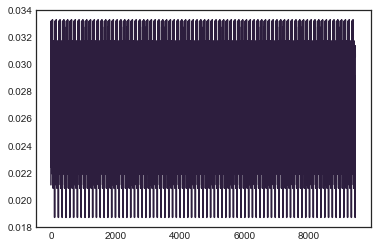

In [64]:
plt.plot(np.tile(np.mean(a[:,:,20],axis=1),80))

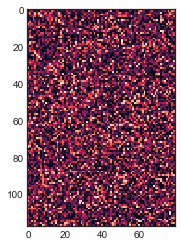

In [57]:
for cell in range(76):
    np.tile(np.mean(images_X_latency[:,cell].reshape(118,80),axis=1),80)

In [72]:
#get the global dt for each image presentation. 
#should a 1d array length imagesxpresentations, which in this case is 118x80
global_dts = np.zeros(np.shape(images_X_counts))

#slice the latency tensor to get all the latencies for a given image. this should then be 118 x Nunits
#get a a mean 
for cell in range(76):
    global_dts[:,cell]=np.tile(np.mean(images_X_latency[:,cell].reshape(118,80),axis=1),80)

images_X_latency_corrected = images_X_latency - global_dts
# images_X_latency_corrected = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps']),
#                      len(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list']))))
# window = 0.1
# for i,image in enumerate(image_ids):
#     print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
#     for j,cell in enumerate(np.array(nwb_data['processing'][probename]['UnitTimes']['unit_list'])):
#             times1= np.array(nwb_data['processing'][probename]['UnitTimes'][cell]['times'])
#             stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'])[i]+0.04
#             post_spikes = times1[times1 > stimulus_time]
#             if len (post_spikes) > 0:
#                 if post_spikes[0] < stimulus_time+window:
#                     images_X_latency_corrected[i][j] = post_spikes[0] -  stimulus_time - global_dts[i]
#                 else: images_X_latency_corrected[i][j] = 0
#             else: images_X_latency_corrected[i][j] = 0

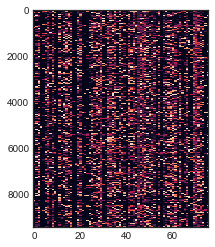

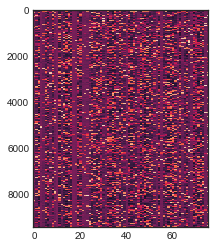

In [73]:
plt.imshow(images_X_latency)
plt.gca().set_aspect(.01)
plt.figure()
plt.imshow(images_X_latency_corrected)
plt.gca().set_aspect(.01)

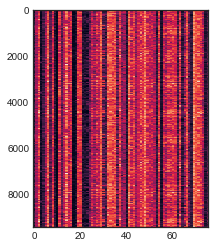

In [70]:
plt.imshow(global_dts)
plt.gca().set_aspect(.01)

In [16]:
images_shuffled_X_counts = np.zeros((len(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['timestamps']),
                     len(np.array(nwb_data['processing']['B']['UnitTimes']['unit_list']))))
window = 0.1
for i,image in enumerate(image_ids):
    print '\r '+str(i)+'/'+str(len(image_ids))+' '+nwb_path+' '+str(i/float(len(image_ids))*100.)+'%',
    for j,cell in enumerate(np.array(nwb_data['processing']['B']['UnitTimes']['unit_list'])):
            times1= np.array(nwb_data['processing']['B']['UnitTimes'][cell]['times'])
            stimulus_time = np.array(nwb_data['stimulus']['presentation']['natural_scenes_shuffled']['timestamps'])[i]+0.04
            post_spikes = times1[times1 > stimulus_time]
            if len (post_spikes) > 0:
                if post_spikes[0] < stimulus_time+window:
                    images_shuffled_X[i][j] = len(post_spikes[post_spikes < stimulus_time+window])
                else: images_shuffled_X[i][j] = 0
            else: images_shuffled_X[i][j] = 0

KeyError: "Unable to open object (object 'natural_scenes_shuffled' doesn't exist)"

In [97]:
images_X = images_X_counts

In [29]:
diffs=[]
good_images = []
for image_no in range(118):
    responses = images_X[image_no::118,:]
    means = np.mean(responses,axis=1)
    diffs.extend([np.max(means)-np.min(means)]) 
diff_images = image_ids[np.argsort(diffs)[::-1]][:30]

maxs=[]
good_images = []
for image_no in range(118):
    responses = images_X[image_no::118,:]
    means = np.mean(responses,axis=1)
    maxs.extend([np.max(means)]) 
big_images = image_ids[np.argsort(maxs)[::-1]][:30]

In [30]:
good_images = big_images
# good_images = diff_images
# good_images = image_ids

In [31]:
images_sub = images_X[np.in1d(image_ids, good_images),:]
images_sub_ids = image_ids[np.in1d(image_ids, good_images)]

In [32]:
images_sub.shape

(2400, 76)

In [101]:
test_size = 60
# images_X_train = images_X[:-test_size]
# images_X_test= images_X[-test_size:]
# images_Y_test = image_ids[-test_size:]
# images_Y_train= image_ids[:-test_size]
images_X_train = images_sub[test_size:]
images_X_test= images_sub[:test_size]
images_Y_test = images_sub_ids[:test_size]
images_Y_train= images_sub_ids[test_size:]

5.0

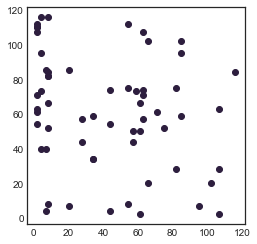

In [102]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

In [103]:
all_predictions = np.zeros((80,30))
correct=  np.zeros((80,30))
for i in range(80):
    test_size = 30
    test_indices = np.arange(30*i,30*i+30,1)
    train_indices = np.delete(np.arange(80*30),test_indices)
    images_X_train = images_sub[train_indices]
    images_X_test= images_sub[test_indices]
    images_Y_test = images_sub_ids[test_indices]
    images_Y_train= images_sub_ids[train_indices]
    KNN.fit(images_X_train, images_Y_train) 
    predictions = KNN.predict(images_X_test)
    all_predictions[i,:]=predictions
    correct[i,:]=predictions == images_Y_test

In [104]:
all_predictions = np.zeros((80,30))
correct=  np.zeros((80,30))
for i in range(80):
    test_size = 30
    test_indices = np.arange(30*i,30*i+30,1)
    train_indices = np.delete(np.arange(80*30),test_indices)
    images_X_train = images_sub[train_indices]
    images_X_test= images_sub[test_indices]
    images_Y_test = images_sub_ids[test_indices]
    images_Y_train= images_sub_ids[train_indices]
    KNN.fit(images_X_train, images_Y_train) 
    predictions = KNN.predict(images_X_test)
    all_predictions[i,:]=predictions
    correct[i,:]=predictions == images_Y_test

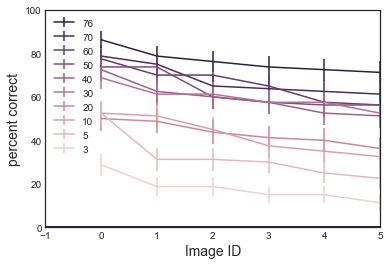

In [106]:
savefig=False
popsize = [76,70,60,50,40,30,20,10,5,3]
for no_neurons in popsize:
    if no_neurons != 76:
        images_sub = images_X[np.in1d(image_ids, good_images),:]
        images_sub=images_sub[:,np.random.randint(0,75,no_neurons)]
    else: images_sub = images_X[np.in1d(image_ids, good_images),:]
    
        
    all_predictions = np.zeros((80,30))
    correct=  np.zeros((80,30))
    
    for i in range(80):
        test_size = 30
        test_indices = np.arange(30*i,30*i+30,1)
        train_indices = np.delete(np.arange(80*30),test_indices)
        images_X_train = images_sub[train_indices]
        images_X_test= images_sub[test_indices]
        images_Y_test = images_sub_ids[test_indices]
        images_Y_train= images_sub_ids[train_indices]
        KNN.fit(images_X_train, images_Y_train) 
        predictions = KNN.predict(images_X_test)
        all_predictions[i,:]=predictions
        correct[i,:]=predictions == images_Y_test
    sorts = np.argsort(np.mean(correct,axis=0))[::-1]
    plt.errorbar(np.arange(30),
                 np.mean(correct,axis=0)[sorts]*100,
                 yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80)*100,
                 label=str(no_neurons))
    plt.gca().axhline(0.03)#,ls='r--')
    plt.ylim(0,100)
plt.legend()
plt.xlabel("Image ID")
plt.ylabel("percent correct")
plt.xlim(-1,5)
if savefig:
    plt.xlim(-1,5)
    plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/KNN_popsize.eps',format='eps')

In [114]:
images_X = images_X_latency
test_size = 70
# images_X_train = images_X[:-test_size]
# images_X_test= images_X[-test_size:]
# images_Y_test = image_ids[-test_size:]
# images_Y_train= image_ids[:-test_size]
images_X_train = images_sub[test_size:]
images_X_test= images_sub[:test_size]
images_Y_test = images_sub_ids[:test_size]
images_Y_train= images_sub_ids[test_size:]

10.0

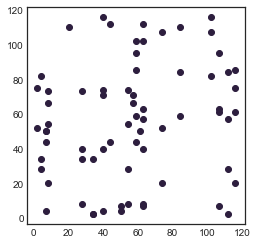

In [120]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=4,
           weights='uniform')
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

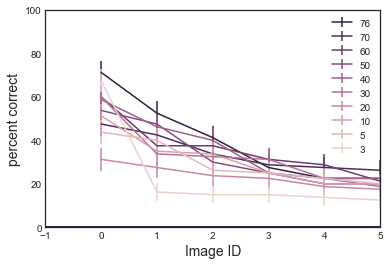

In [121]:
savefig=True
popsize = [76,70,60,50,40,30,20,10,5,3]
for no_neurons in popsize:
    if no_neurons != 76:
        images_sub = images_X[np.in1d(image_ids, good_images),:]
        images_sub=images_sub[:,np.random.randint(0,75,no_neurons)]
    else: images_sub = images_X[np.in1d(image_ids, good_images),:]
    
        
    all_predictions = np.zeros((80,30))
    correct=  np.zeros((80,30))
    
    for i in range(80):
        test_size = 30
        test_indices = np.arange(30*i,30*i+30,1)
        train_indices = np.delete(np.arange(80*30),test_indices)
        images_X_train = images_sub[train_indices]
        images_X_test= images_sub[test_indices]
        images_Y_test = images_sub_ids[test_indices]
        images_Y_train= images_sub_ids[train_indices]
        KNN.fit(images_X_train, images_Y_train) 
        predictions = KNN.predict(images_X_test)
        all_predictions[i,:]=predictions
        correct[i,:]=predictions == images_Y_test
    sorts = np.argsort(np.mean(correct,axis=0))[::-1]
    plt.errorbar(np.arange(30),
                 np.mean(correct,axis=0)[sorts]*100,
                 yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80)*100,
                 label=str(no_neurons))
    plt.gca().axhline(0.03)#,ls='r--')
    plt.ylim(0,100)
plt.legend()
plt.xlabel("Image ID")
plt.ylabel("percent correct")
plt.xlim(-1,5)
if savefig:
    plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/KNN_popsize_latency1.eps',format='eps')

In [110]:
images_X = images_X_latency_corrected
test_size = 60
# images_X_train = images_X[:-test_size]
# images_X_test= images_X[-test_size:]
# images_Y_test = image_ids[-test_size:]
# images_Y_train= image_ids[:-test_size]
images_X_train = images_sub[test_size:]
images_X_test= images_sub[:test_size]
images_Y_test = images_sub_ids[:test_size]
images_Y_train= images_sub_ids[test_size:]

3.3333333333333335

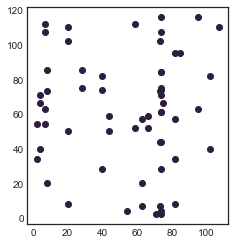

In [111]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

In [1]:
savefig=True
popsize = [76,70,60,50,40,30,20,10,5,3]
for no_neurons in popsize:
    if no_neurons != 76:
        images_sub = images_X[np.in1d(image_ids, good_images),:]
        images_sub=images_sub[:,np.random.randint(0,75,no_neurons)]
    else: images_sub = images_X[np.in1d(image_ids, good_images),:]
    
        
    all_predictions = np.zeros((80,30))
    correct=  np.zeros((80,30))
    
    for i in range(80):
        test_size = 30
        test_indices = np.arange(30*i,30*i+30,1)
        train_indices = np.delete(np.arange(80*30),test_indices)
        images_X_train = images_sub[train_indices]
        images_X_test= images_sub[test_indices]
        images_Y_test = images_sub_ids[test_indices]
        images_Y_train= images_sub_ids[train_indices]
        KNN.fit(images_X_train, images_Y_train) 
        predictions = KNN.predict(images_X_test)
        all_predictions[i,:]=predictions
        correct[i,:]=predictions == images_Y_test
    sorts = np.argsort(np.mean(correct,axis=0))[::-1]
    plt.errorbar(np.arange(30),
                 np.mean(correct,axis=0)[sorts]*100,
                 yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80)*100,
                 label=str(no_neurons))
    plt.gca().axhline(0.03)#,ls='r--')
    plt.ylim(0,100)
plt.legend()
plt.xlabel("Image ID")
plt.ylabel("percent correct")
# plt.xlim(-1,5)
if savefig:
    plt.gcf().savefig('/Users/administrator/Dropbox/allenTransfer/KNN_popsize_latency_corrected1.eps',format='eps')

NameError: name 'images_X' is not defined

In [591]:
images_sub[:,np.random.randint(0,75,no_neurons)].shape

(2400, 70)

In [576]:
images_sub.shape

(2400, 76)

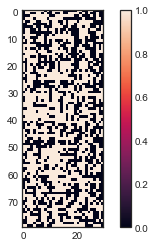

In [569]:
plt.imshow(correct,interpolation='none')
plt.colorbar()

(0, 1)

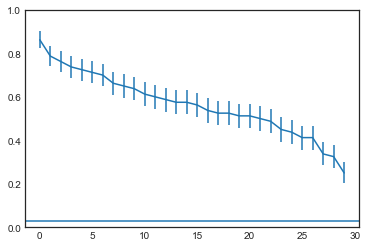

In [570]:
sorts = np.argsort(np.mean(correct,axis=0))[::-1]
plt.errorbar(np.arange(30),np.mean(correct,axis=0)[sorts],yerr=np.std(correct,axis=0)[sorts]/np.sqrt(80))
plt.gca().axhline(0.03)#,ls='r--')
plt.ylim(0,1)

40.0

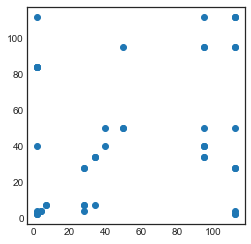

In [516]:
SVC = svm.SVC(gamma=5,C=1)
SVC.fit(images_X_train, images_Y_train) 
predictions = SVC.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)
sum(predictions == images_Y_test) / float(test_size) * 100.

#### sum(predictions == images_Y_test)

In [417]:
predictions == images_Y_test

array([ True, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
        True, False, False, False,  True, False,  True, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,

In [247]:
images_shuffled_X_train = images_shuffled_X[:-500]
images_shuffled_X_test= images_shuffled_X[-500:]
images_shuffled_Y_test = shuffled_image_ids[-500:]
images_shuffled_Y_train= shuffled_image_ids[:-500]

In [248]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

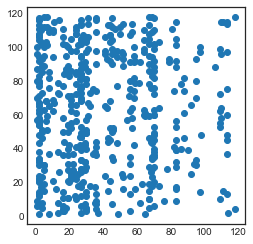

In [249]:
KNN.fit(images_X_train, images_Y_train) 
predictions = KNN.predict(images_X_test)
plt.plot(predictions,images_Y_test,'o')
plt.gca().set_aspect(1)